# Convolutional Neural Network (CNN)
https://www.tensorflow.org/tutorials/images/cnn

該筆記本演示使用Watson Machine Learning訓練和評分深度學習模型

將展示如何經過訓練的深度學習模型保存為本地的.tgz文件並且將模型線上部署

該筆記本使用tf.keras 2.2.4和watson-machine-learning-client-V4

該筆記本與DAS 2.5和Python 3.6兼容

# 學習目標:
在筆記本中，您將學習如何：

- 使用Watson Machine Learning在線部署/評分深度學習（Keras）模型。
- 建立深度學習（Keras）模型並進行訓練。
- 在Watson Machine Learning存儲庫中將訓練後的模型另存為.tgz文件。
- 在線部署經過訓練的模型並對其評分。

# 1.設置
要開始使用DAS，請找到有關安裝的文檔並在此處進行設置。

- Python環境配置：
    - Python 3.6
    - Tensorflow 1.14.0
    - watson-machine-learning-client-V4（下面的運行代碼進行安裝）
    - matplotlib（下面的運行代碼進行安裝）

## 在DAS上驗證Python客戶端。

如需要驗證客戶端請按照[Documentation](https://www.ibm.com/support/knowledgecenter/SSQNUZ_current/wsj/analyze-data/ml-authentication-local.html)步驟。

Action: 輸入您的驗證訊息如下

Import watson-machine-learning-client and authenticate the service instance.

In [1]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.0.0"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

您透過此 [連結](https://wml-api-pyclient-dev-v4.mybluemix.net/) 找到watsoon-machine-learning-client-V4相關文檔。

# 2. 資料

在本部分中，在使用輸入數據訓練模型之前進行資料的觀察。 

需要模組keras.datasets.cifar10和matplotlib.pyplot來查看每張圖片。

## 2.1 匯入資料

從keras.datasets.cifar10模塊導入cifar10數據集，然後將數據集分為訓練和測試數據集。

In [2]:
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras import backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # use GPU training
%matplotlib inline 

In [3]:
tf.__version__

'1.15.2'

In [4]:
keras.__version__

'2.2.5'

下載資料

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 14s 0us/step


## 2.2 資料展示

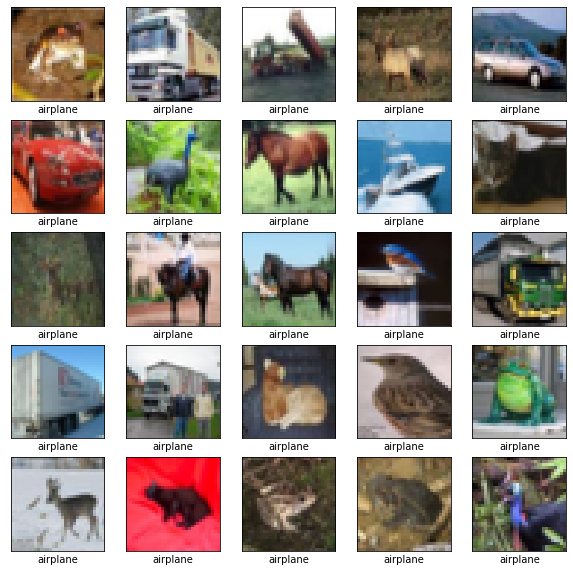

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()


## 2.3 檢查資料維度

# 3. 模型的訓練與評估

本部分中，您將建立一個深度學習（Keras）模型，對其進行訓練和評估。

導入所需的軟件包和模塊。

## 下載預先訓練模型 (use for demo)

In [ ]:
# !curl --insecure https://thisismys3.s3.twcc.ai/cifar10-cnn-model.h5 --output cifar10-cnn-model-s3.h5

In [ ]:
# from keras.models import load_model
# model = load_model('cifar10-cnn-model-s3.h5')

參數設定

In [7]:
batch_size = 64
num_classes = 10
epochs = 5
input_shape = (32, 32, 3)

In [8]:
# Convert class vectors to binary class matrices.
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [9]:
print('X_train shape:', train_images.shape)
print('y_train shape:', train_labels.shape)
print('X_test shape:', test_images.shape)
print('y_test shape:', test_labels.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


-----------------

## 3.1 模型及訓練

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

模型摘要

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)         

In [12]:
%%time
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 29s 589us/step - loss: 1.5918 - acc: 0.4266 - val_loss: 1.5487 - val_acc: 0.4644
Epoch 2/5
50000/50000 [==============================] - 28s 560us/step - loss: 1.1360 - acc: 0.6013 - val_loss: 1.0851 - val_acc: 0.6074
Epoch 3/5
50000/50000 [==============================] - 29s 583us/step - loss: 0.9729 - acc: 0.6643 - val_loss: 0.9453 - val_acc: 0.6704
Epoch 4/5
50000/50000 [==============================] - 29s 573us/step - loss: 0.8872 - acc: 0.6931 - val_loss: 1.4570 - val_acc: 0.5786
Epoch 5/5
50000/50000 [==============================] - 28s 557us/step - loss: 0.8432 - acc: 0.7120 - val_loss: 0.7739 - val_acc: 0.7403
CPU times: user 29min 58s, sys: 31.6 s, total: 30min 29s
Wall time: 2min 23s


在訓練和驗證（測試）數據集上繪製模型準確性。 

使用給定的代碼，以R的ggplot樣式繪製圖形。

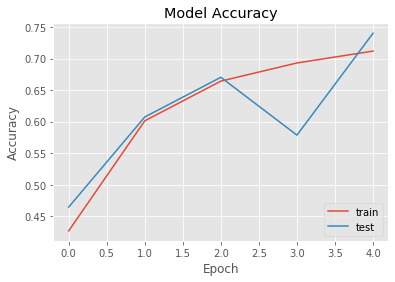

In [13]:
plt.style.use('ggplot')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

在訓練和驗證（測試）數據集上繪製模型的loss。

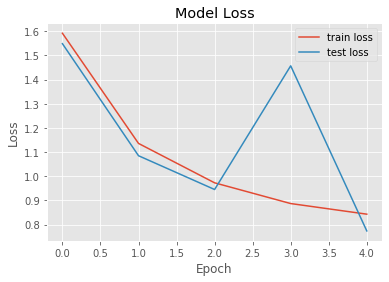

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')

--------------

## 3.2 模型評估

在本節中，您將評估模型並對其準確性進行評分。

In [15]:
score = model.evaluate(test_images, test_labels, verbose=0)

In [16]:
print('Test loss:', score[0])
print('Test accuracy: {:.2f}%'.format(score[1]*100))

Test loss: 0.7739364696502685
Test accuracy: 74.03%


# 4. 模型儲存本地端

在本部分中，將學習如何在本地保存訓練後的深度學習（Keras）模型並將其壓縮到.tgz文件中。

首先，在本地保存Keras模型。

In [17]:
from contextlib import suppress

# model file name
filename = 'cifar10-cnn-model.h5' 

# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
    
model.save(filename)

將Keras模型文件壓縮為.tgz文件。 

確保在運行tar命令時添加z標誌。

## compress keras model

In [18]:
filename = 'cifar10-cnn-model.h5' 
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
os.system(cmdstring)

0

您可以看到模型文件cifar10_cnn_model.h5及壓縮版本cifar10_cnn_model.h5.tgz都保存在本地文件系統中。

In [19]:
!ls

cifar10-cnn-model.h5  cifar10-cnn-model.h5.tgz


# 5.創建在線部署(online deployment)

在本節中，您將學習部署訓練完成模型的壓縮版本（即.tgz文件），由上節所完成之檔案。

在“訓練”部分中定義訓練模型的元數據並評估模型。 您可以使用以下代碼獲取空間uid（模型元數據中的元名稱之一）。

In [20]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'cifar10_deployment_space'
model_name = "cifar10 - compressed keras model"
deployment_name = 'cifar10-model-deployment'

## Create the space and set it as default

In [21]:

space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name,
        client.spaces.ConfigurationMetaNames.TAGS : [{'value': 'cifar10_model_space_tag'}]
}

stored_space_details = client.spaces.store(space_meta_data)

space_uid = stored_space_details['metadata']['guid']
print(space_uid)

6812117c-b4e2-4f63-bddd-a917c9ea026b


## Define model metadata

In [22]:
meta_props={
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.RUNTIME_UID: "tensorflow_1.15-py3.6", # use predefined runtime
    client.repository.ModelMetaNames.TYPE: "keras_2.2.5",
#     client.repository.ModelMetaNames.SPACE_UID: space_uid
}

## Predefined runtime list

In [23]:
client.set.default_space(space_uid)
client.runtimes.list(pre_defined=True)

WARNING!! 'runtimes' is DEPRECATED. Use 'software_specifications' instead to create and manage runtimes/specifications
WARNING!! 'runtimes' is DEPRECATED. Use 'software_specifications' instead to create and manage runtimes/specifications
-----------------------  -----------------------  ------------------------  --------
GUID                     NAME                     CREATED                   PLATFORM
do_12.10                 do_12.10                 2020-08-18T03:34:01.221Z  do
do_12.9                  do_12.9                  2020-08-18T03:34:01.201Z  do
pmml_4.3                 pmml_4.3                 2020-08-18T03:34:01.182Z  pmml
pmml_4.2.1               pmml_4.2.1               2020-08-18T03:34:01.164Z  pmml
pmml_4.2                 pmml_4.2                 2020-08-18T03:34:01.145Z  pmml
pmml_4.1                 pmml_4.1                 2020-08-18T03:34:01.125Z  pmml
pmml_4.0                 pmml_4.0                 2020-08-18T03:34:01.104Z  pmml
pmml_3.2                 pmml

## Store Model
### (1) Save to deployment space

In [24]:
client.set.default_space(space_uid)

'SUCCESS'

### (2) Save to project (option)

In [25]:
# client.set.default_project(os.environ['PROJECT_ID'])

## Create the model artifact

In [26]:
model_artifact = client.repository.store_model(tar_filename, meta_props=meta_props, training_data=train_images, training_target=train_labels)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)
model_artifact

Model UID = 0b549dd0-f6b0-483f-b049-04d20de64508


{'metadata': {'name': 'cifar10 - compressed keras model',
  'guid': '0b549dd0-f6b0-483f-b049-04d20de64508',
  'id': '0b549dd0-f6b0-483f-b049-04d20de64508',
  'modified_at': '2020-08-25T03:51:39.002Z',
  'created_at': '2020-08-25T03:51:38.002Z',
  'owner': '1000331004',
  'href': '/v4/models/0b549dd0-f6b0-483f-b049-04d20de64508?space_id=6812117c-b4e2-4f63-bddd-a917c9ea026b',
  'space_id': '6812117c-b4e2-4f63-bddd-a917c9ea026b'},
 'entity': {'name': 'cifar10 - compressed keras model',
  'content_status': {'state': 'persisted'},
  'space': {'id': '6812117c-b4e2-4f63-bddd-a917c9ea026b',
   'href': '/v4/spaces/6812117c-b4e2-4f63-bddd-a917c9ea026b'},
  'type': 'keras_2.2.5',
  'runtime': {'id': 'tensorflow_1.15-py3.6',
   'href': '/v4/runtimes/tensorflow_1.15-py3.6'}}}

## Metadata of deployment 

In [27]:
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : [{'value' : 'cifar10_demo'}],
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

## Create the deployment

In [28]:
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '0b549dd0-f6b0-483f-b049-04d20de64508' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f0aea7cf-87ae-4589-9834-956538ce9fb2'
------------------------------------------------------------------------------------------------




## Delete model in repository(option)

In [29]:
# for model in client.repository.get_model_details()['resources']:
#     guid = model['metadata']['guid']
#     client.repository.delete(guid)

# for deploy in client.deployments.get_details()['resources']:
#     guid = deploy['metadata']['guid']
#     client.deployments.delete(guid)

## List the deployments

In [30]:
client.deployments.list()

------------------------------------  ------------------------  -----  ------------------------  -------------
GUID                                  NAME                      STATE  CREATED                   ARTIFACT_TYPE
f0aea7cf-87ae-4589-9834-956538ce9fb2  cifar10-model-deployment  ready  2020-08-25T03:51:39.646Z  model
------------------------------------  ------------------------  -----  ------------------------  -------------


## Deployment UID

In [31]:
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = f0aea7cf-87ae-4589-9834-956538ce9fb2


# 6. 模型預測分數評估

本部分將學習如何對測試數據記錄進行評分。

X_test的第一位數字將用於評分。

## Prepare scoring payload

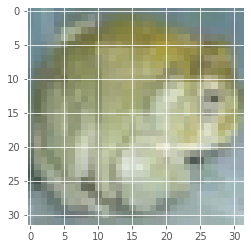

In [32]:
import random

idx = random.randint(0, len(train_images))
scoring_data = train_images[idx].tolist()
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [scoring_data]
    }]
}

plt.imshow(train_images[idx], cmap=plt.cm.binary)
plt.show()

## Perform prediction and display the result.

In [33]:
job_details = client.deployments.score(deployment_uid,
                                           job_payload)
print(job_details)

{'predictions': [{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[0.0007481984794139862, 0.00016350917576346546, 0.060248952358961105, 0.05789670720696449, 0.08540784567594528, 0.012024861760437489, 0.7811720371246338, 0.0014949290780350566, 0.0003335033543407917, 0.000509459525346756], 6, [0.0007481984794139862, 0.00016350917576346546, 0.060248952358961105, 0.05789670720696449, 0.08540784567594528, 0.012024861760437489, 0.7811720371246338, 0.0014949290780350566, 0.0003335033543407917, 0.000509459525346756]]]}]}


In [34]:
prediction_classes = job_details['predictions'][0]['values'][0][1]
print(class_names[prediction_classes])

frog
